# Lab 05 : Final code -- demo

In [3]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'final_demo.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import utils

### Download the data

In [5]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

### Make a one layer net class. 

In [6]:
class one_layer_net(nn.Module):

    def __init__(self, input_size, output_size):
        super(one_layer_net , self).__init__()
        self.linear_layer = nn.Linear( input_size, output_size , bias=False)
        
    def forward(self, x):
        scores = self.linear_layer(x)
        return scores

### Build the net

In [12]:
net=one_layer_net(784,10)

print(net)
utils.display_num_param(net)

one_layer_net(
  (linear_layer): Linear(in_features=784, out_features=10, bias=False)
)
There are 7840 (0.01 million) parameters in this neural network


### Choose the criterion, batchsize

In [13]:
criterion = nn.CrossEntropyLoss()

bs=200

### Evaluate on test set

In [14]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        inputs = minibatch_data.view(bs,784)

        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

### Training loop

In [15]:
start = time.time()

total_loss = 0
total_error = 0

lr = 0.05 # initial learning rate

for epoch in range(200):
    
    # learning rate strategy : divide the learning rate by 1.5 every 10 epochs
    if epoch%10==0 and epoch>10: 
        lr = lr / 1.5
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # forward and backward pass
    
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label= train_label[indices]

        inputs = minibatch_data.view(bs,784)

        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute some stats
        
        running_loss += loss.detach().item()
               
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed_time = time.time() - start
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set  
    
    if epoch % 10 == 0 : 
    
        print(' ')
        
        print('epoch=',epoch, ' time=', elapsed_time,
              ' loss=', total_loss , ' error=', total_error*100 ,'percent lr=', lr)
        
        eval_on_test_set()
               

 
epoch= 0  time= 0.823448896408081  loss= 0.8325826582312584  error= 17.948332965373993 percent lr= 0.05
test error  =  12.259999990463257 percent
 
epoch= 10  time= 8.433445692062378  loss= 0.3308516465127468  error= 9.208333392937979 percent lr= 0.05
test error  =  8.65999984741211 percent
 
epoch= 20  time= 16.22564125061035  loss= 0.30605158338944116  error= 8.509999950726826 percent lr= 0.03333333333333333
test error  =  8.239999532699585 percent
 
epoch= 30  time= 25.2508327960968  loss= 0.29756426125764845  error= 8.25666638215383 percent lr= 0.022222222222222223
test error  =  8.120000004768372 percent
 
epoch= 40  time= 34.31163477897644  loss= 0.29328706830739976  error= 8.15833326180776 percent lr= 0.014814814814814815
test error  =  8.089999794960022 percent
 
epoch= 50  time= 41.67644262313843  loss= 0.2908958262701829  error= 8.078333218892416 percent lr= 0.009876543209876543
test error  =  8.049999952316284 percent
 
epoch= 60  time= 48.70795273780823  loss= 0.289435692

### Choose image at random from the test set and see how good/bad are the predictions

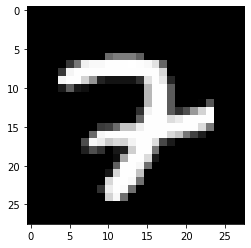

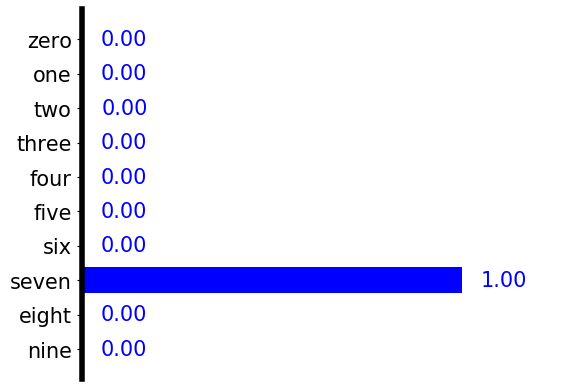

In [16]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,784)) 
probs= F.softmax(scores, dim=1)
utils.show_prob_mnist(probs)